In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = pd.read_csv('../data/ads_all_cleaned.csv')
df['age'] = datetime.datetime.now().year - df['year']

# Outlier Analysis

## Price Outliers

Heavy outliers in Mercedes-Benz with some in Lexus, Ford and Audi.

<Axes: title={'center': 'price'}, xlabel='[brand]'>

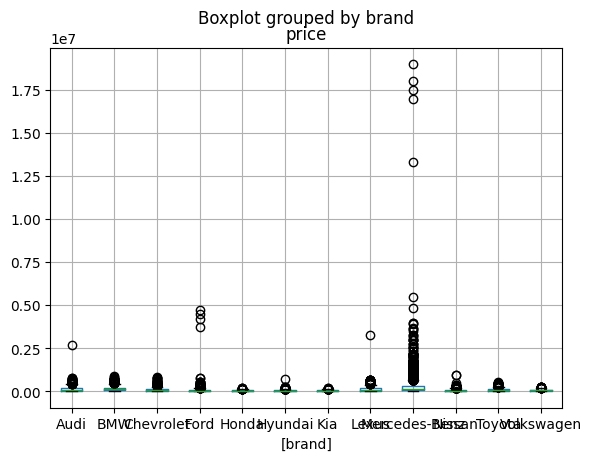

In [2]:
df[['brand','price']].boxplot(by='brand')

Most outliers are from Mercedez

We'll using the following formula to determine what is an outlier and what is not:

Upper Outlier: Q3 + 1.5*IQR

Lower Outlier: Q1 - 1.5*IQR

In [3]:
df['price'].describe()

count    2.087200e+04
mean     1.511789e+05
std      3.470906e+05
min      5.000000e+03
25%      4.000000e+04
50%      8.199900e+04
75%      1.720000e+05
max      1.899900e+07
Name: price, dtype: float64

In [4]:
Q1 = df['price'].describe()[4]
Q3 = df['price'].describe()[6]
IQR = Q3-Q1
outlier_upper = Q3 + 1.5*IQR
outlier_lower = Q1 - 1.5*IQR

In [5]:
outlier_upper

370000.0

**Plotting boxplot for different thresholds of outlier limits**

This is how the boxplot now looks with the outliers removed but I feel this is quite a tight limit.

I'm going to try increasing it to 500,000 and then 1,000,000 just to see the difference

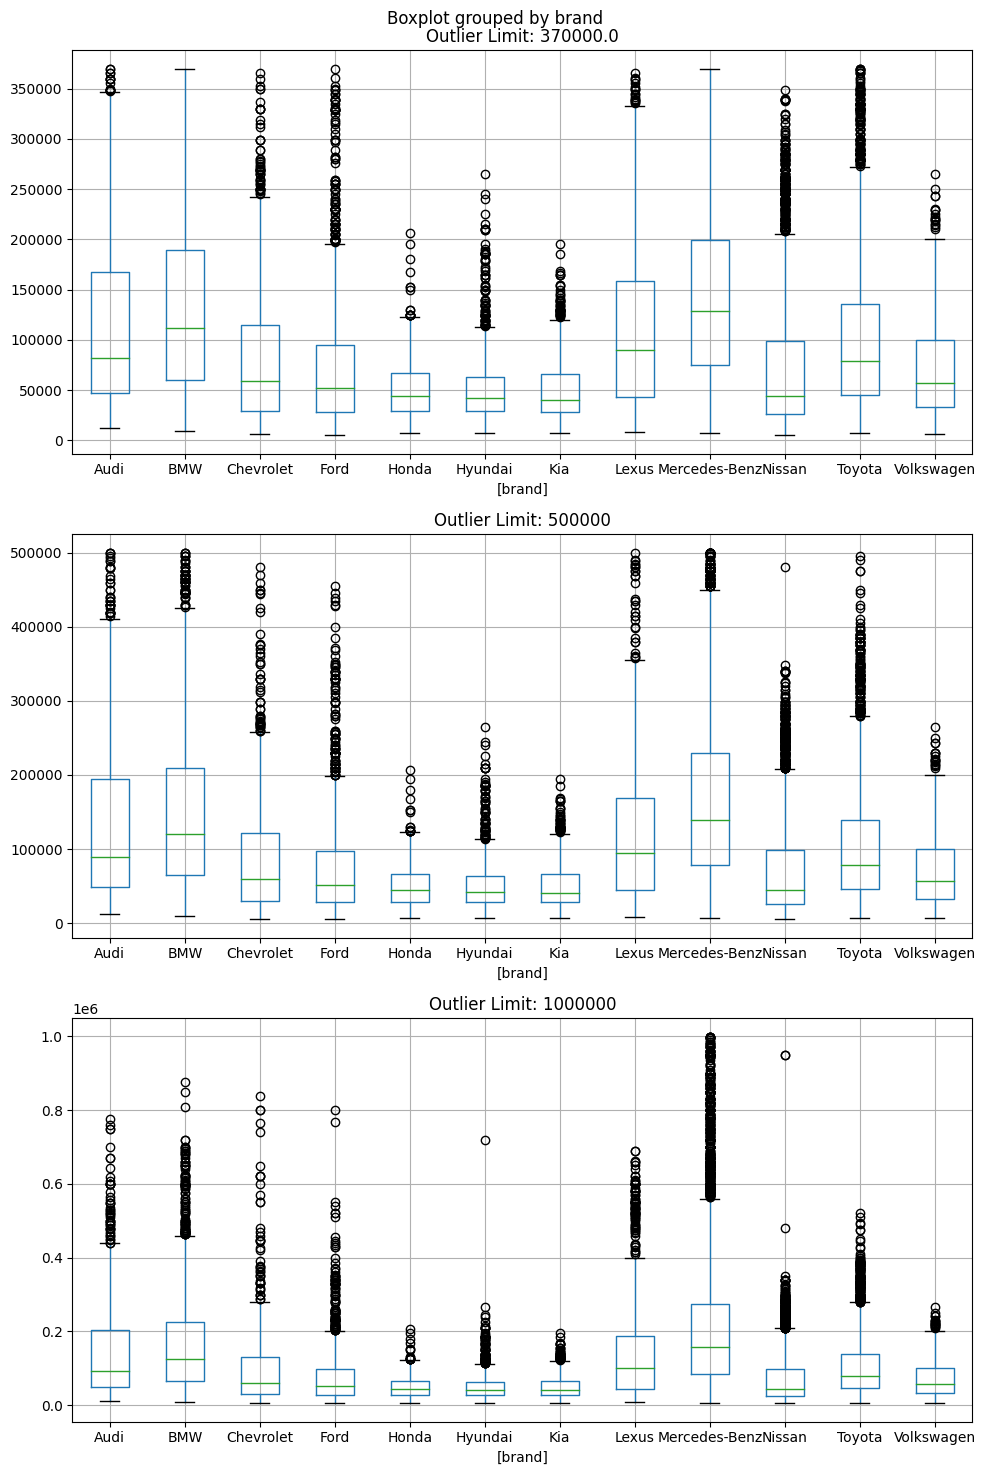

In [6]:
# List of outlier_upper values you want to try
outlier_values = [outlier_upper, 500000, 1000000]

# Create a figure and axes with matplotlib
fig, axs = plt.subplots(len(outlier_values), figsize=(10, 5*len(outlier_values)))

for i, outlier_val in enumerate(outlier_values):
    (
        df[df['price'] < outlier_val]
        .loc[:, ['brand','price']]
        .boxplot(by='brand', ax=axs[i])
    )

    # Set the title for the current plot
    axs[i].set_title(f'Outlier Limit: {outlier_val}')

# Show the plots
plt.tight_layout()
plt.show()

Most outliers are coming from Mercedes

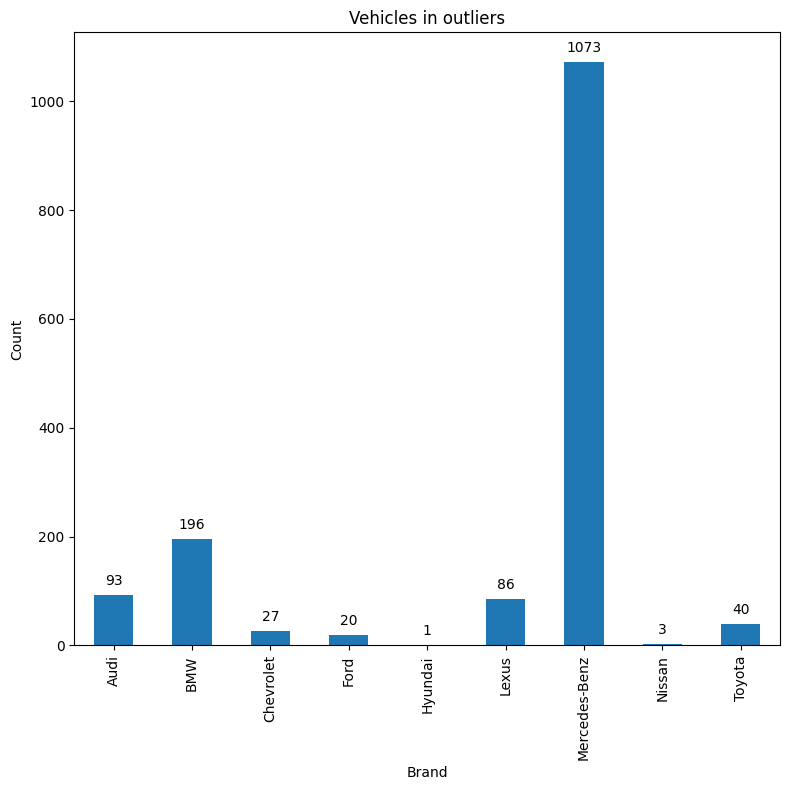

In [92]:
import matplotlib.pyplot as plt

# Create the bar plot
ax = (
    df[df['price'] > outlier_upper]
    .groupby(['brand'])['price']
    .size()
    .plot(kind='bar', figsize=(8, 8))
)

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set labels and title for better readability
ax.set_xlabel('Brand')
ax.set_ylabel('Count')
ax.set_title('Vehicles in outliers')

plt.tight_layout()
plt.show()


Some Mercedes car without a model name seems to be the highest in price

<Axes: xlabel='brand,model'>

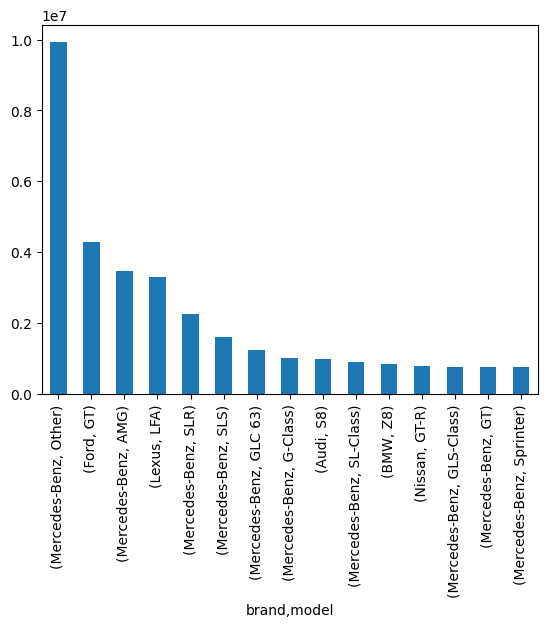

In [8]:
(
    df[df['price'] > outlier_upper]
    .groupby(['brand','model'])['price']
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='bar')
)

### Exploring Mercedez Outliers

This 'Other' vehicle is way out of line. Would be interesting to see what exactly this car is and why it's worth so much.

The price of these top 5 cars are significantly out of range from the rest of the outliers. Definetly need to remove them.

In [9]:
(
    df[(df['price'] > 1000000) & (df['brand'] == 'Mercedes-Benz')]
    .sort_values(by='price', ascending=False)
    .loc[:,['brand','model','title','km','year','price']]
    .head(15)
)

,brand,model,title,km,year,price
17927,Mercedes-Benz,Other,"MERCEDES PROJECT ONE, 2024, LIMITED EDITION, Z...",0,2024,18999000
15756,Mercedes-Benz,AMG,MERCEDES AMG ONE I 1/275 I Brand New,50,2023,18000000
17536,Mercedes-Benz,AMG,Mercedes-Benz AMG ONE,83,2023,17500000
14972,Mercedes-Benz,AMG,2023 Mercedes Benz AMG ONE | Brand New | 1 of ...,0,2023,16999999
18669,Mercedes-Benz,SL-Class,MERCEDES-BENZ 300 SL GULLWING,0,1956,13299999
14994,Mercedes-Benz,G-Class,BRABUS CRAWLER 900 I 1/15 made I Brand New,50,2023,5500000
15527,Mercedes-Benz,G-Class,BRABUS CRAWLER 1 of 15 G900 G63 AMG,30,2023,4830000
14971,Mercedes-Benz,SLS,Mercedes- Benz SLS AMG Black Series | Brand Ne...,0,2014,3999999
16850,Mercedes-Benz,SLS,Mercedes-Benz SLS AMG Black Series 2014 - GCC,829,2014,3950000
16185,Mercedes-Benz,G-Class,"MERCEDES-BENZ BRABUS P900 ROCKET,2024- LIMITED...",214,2024,3900000


**Approaches to take for handling outliers**:
- We may be getting rid of all instances of the car models mentioned below which could impact the model. Meaning if someone were to try and get a price estimate for a G Wagon (a very popular Mercedes car) there will be no data for it
- Determine percentage of data points that would be removed to see potential impact

<Axes: xlabel='model'>

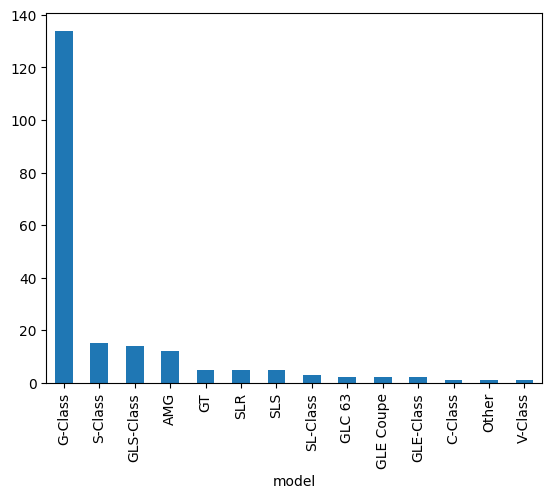

In [10]:
(
    df[(df['price'] > 1000000) & (df['brand'] == 'Mercedes-Benz')]
    .groupby('model')
    .size()
    .sort_values(ascending=False)
    .plot(kind='bar')
)

Determining how many of these cars are outliers out of the whole dataset

Seems like we will be getting rid of a lot of G-Class and S-Class cars both as a percentage and absolute value if we were to use outlier_upper (370,000) as a threshold

I've also included graphs to see how this differs for different outlier thresholds

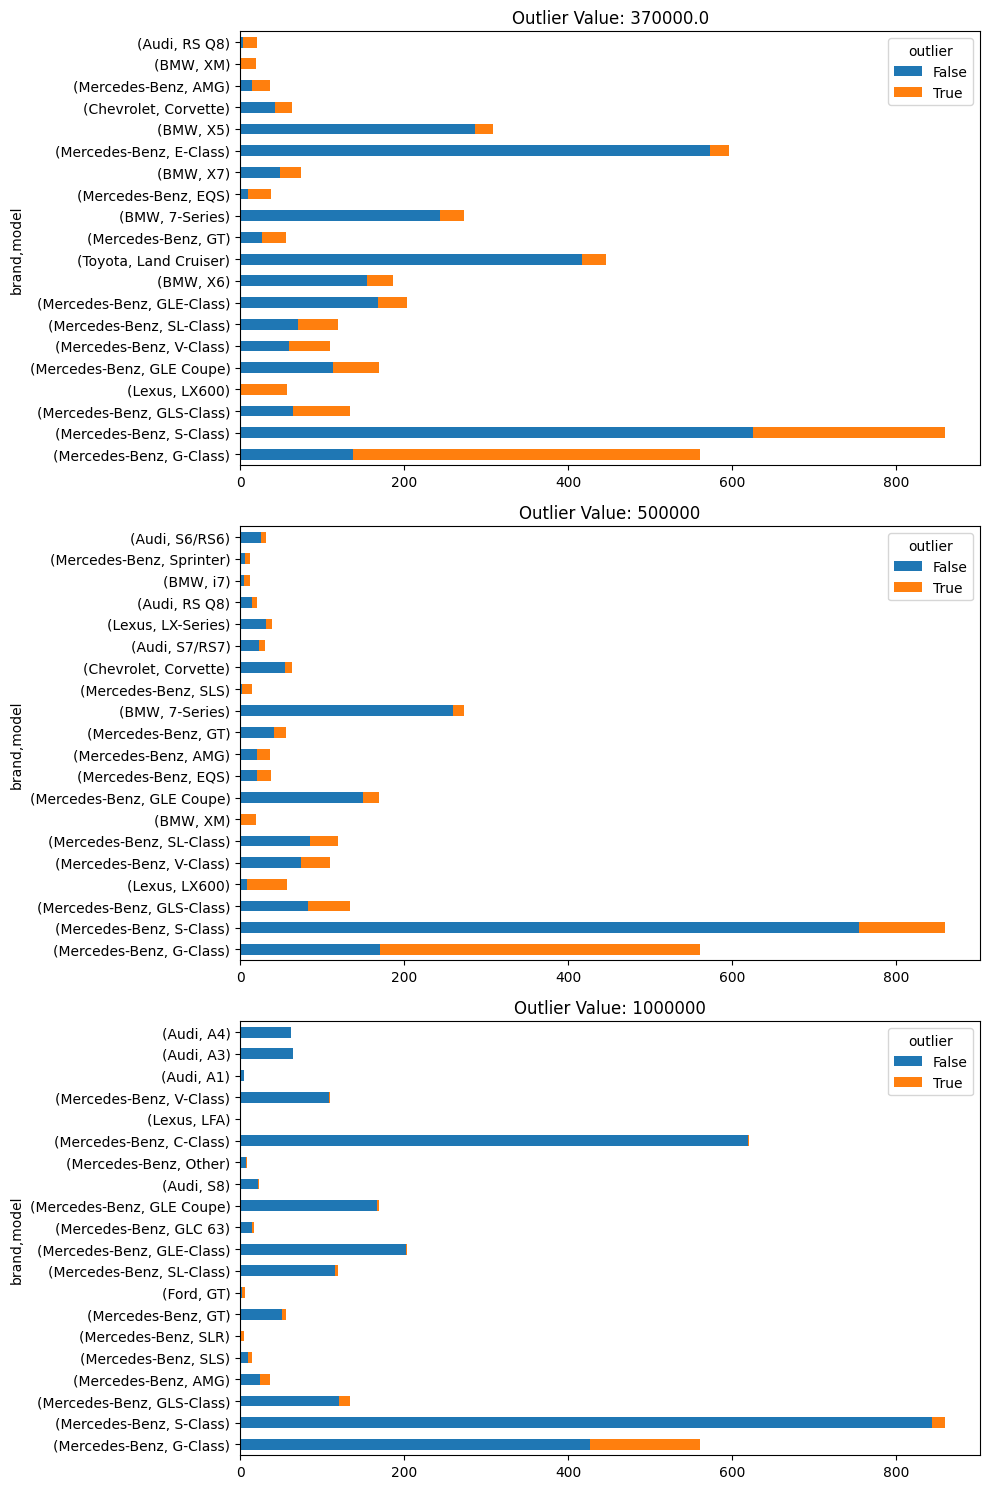

In [11]:
# List of outlier_upper values you want to try
outlier_values = [outlier_upper, 500000, 1000000]

# Create a figure and axes with matplotlib
fig, axs = plt.subplots(len(outlier_values), figsize=(10, 5*len(outlier_values)))

for i, outlier_val in enumerate(outlier_values):
    # Create the plot for the current value of outlier_upper
    (
        df
        .assign(outlier=lambda df: df['price'] > outlier_val)
        .groupby(['brand', 'model', 'outlier'])
        .size()
        .unstack()
        .sort_values(by=True, ascending=False)
        .head(20)
        .plot(kind='barh', stacked=True, ax=axs[i])
    )
    
    # Set the title for the current plot
    axs[i].set_title(f'Outlier Value: {outlier_val}')

# Show the plots
plt.tight_layout()
plt.show()


Doesn't look like we're going to be getting rid of any particular car entirely

<Axes: xlabel='brand,model'>

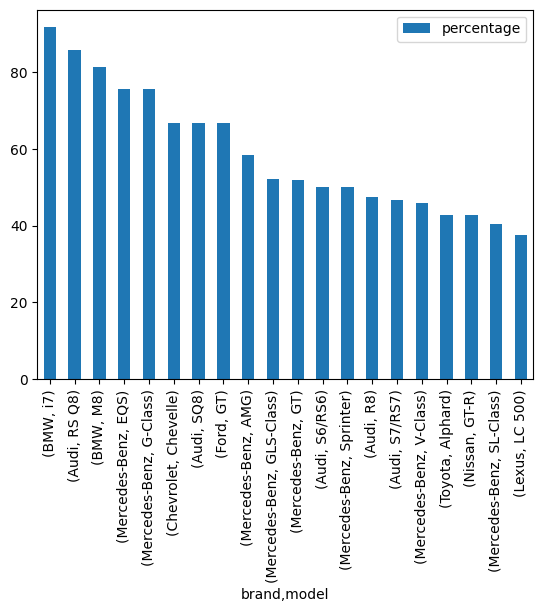

In [12]:
(
    df
    .assign(outlier = lambda df: df['price'] > outlier_upper)
    .groupby(['brand','model','outlier'])
    .size()
    .unstack()
    .assign(percentage = lambda df: (df[True] / (df[True] + df[False])) * 100)
    .sort_values(by='percentage', ascending=False)
    .head(20)
    .plot(kind='bar', y='percentage')
)

## Mileage Outliers

In [13]:
df_outlier_removed = df[df['price'] < outlier_upper]

<Axes: >

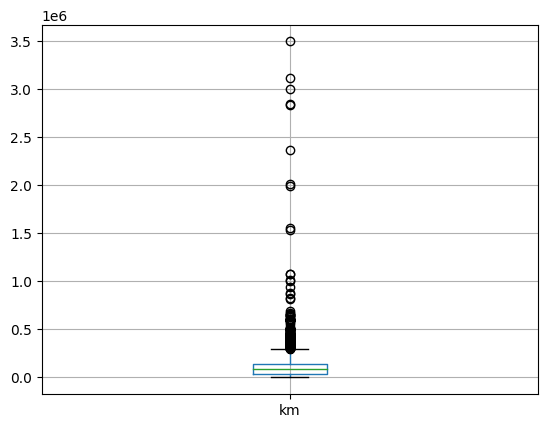

In [14]:
df_outlier_removed[['km']].boxplot()

In [15]:
df_outlier_removed = df_outlier_removed[df_outlier_removed['km'] < 500000]

Only 45 items have km > 500,000. I will drop these as users will not look into buying a car that has done more than 500,000 km.

And if someone is selling such a car, they shouldn't.

## Age Outliers

<Axes: >

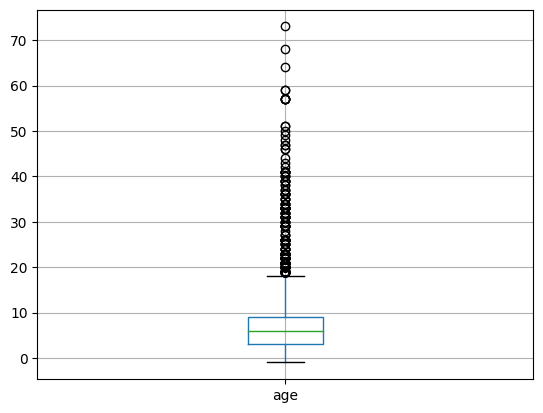

In [16]:
df_outlier_removed[['age']].boxplot()

In [17]:
df_outlier_removed = df_outlier_removed[df_outlier_removed['age'] < 30]

Again, as we are trying to model for average users, we will put a cap at 30 seeing as no average person will probably buy a car that is over 30 years old.

We'll only be removing about 80 items from the list which is bearable.

### Outlier Removal Conclusion
We can use the IQR formula for dropping outliers in price. We don't seem to be losing too much data and the 1,000,000 threshold seems to still have plenty outliers so that wouldn't be a good option.

I will however keep the original dataset with outliers to compare against during the modelling phase of the project.

# Descriptive Statistics

<Axes: >

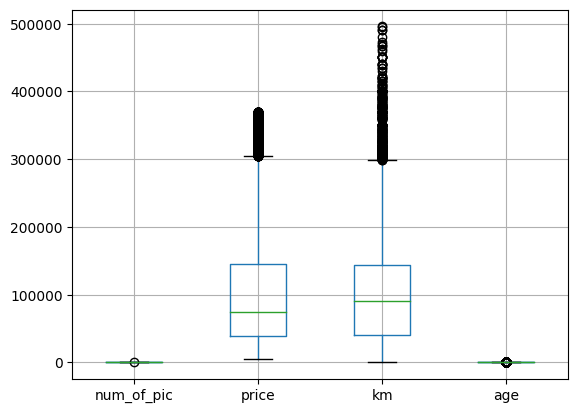

In [18]:
(
    df_outlier_removed
    .drop(['id','year'], axis=1)
    .boxplot()
)

In [19]:
df_outlier_removed[df_outlier_removed['title'].str.lower().str.contains('accident') == True]['title'].values

array(['Ford Explorer 2015 No Accident Full Option 7 Seats',
       'Ford Ecosport trend GCC accident free',
       'Ford Mustang V8 GT gcc first owner with service history 1 year warranty no paint Accident',
       ..., '2017 VW GOLF R | LOW KM | 305BHP | GCC | ACCIDENT FREE',
       'Touareg Highline. Mint condition. No accidents,',
       'Volkswagen Tiguan Sport 2.0 TSI 2018 GCC Specs (Full Service History / Accident Free / 2 Keys)'],
      dtype=object)

In [20]:
df_outlier_removed['age_km'] = df_outlier_removed['age'] * df_outlier_removed['km']

In [21]:
df_outlier_removed[['price','km','age','age_km','num_of_pic']].corr()

,price,km,age,age_km,num_of_pic
price,1.000000,-0.534710,-0.547497,-0.490187,0.210701
km,-0.534710,1.000000,0.689639,0.879028,-0.262407
age,-0.547497,0.689639,1.000000,0.827182,-0.196691
age_km,-0.490187,0.879028,0.827182,1.000000,-0.248217
num_of_pic,0.210701,-0.262407,-0.196691,-0.248217,1.000000


In [22]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.05)
    Q3 = data[column].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return data[(data[column] < lower) | (data[column] > upper)]

In [23]:
brands = df_outlier_removed['brand'].unique()

In [24]:
import seaborn as sns

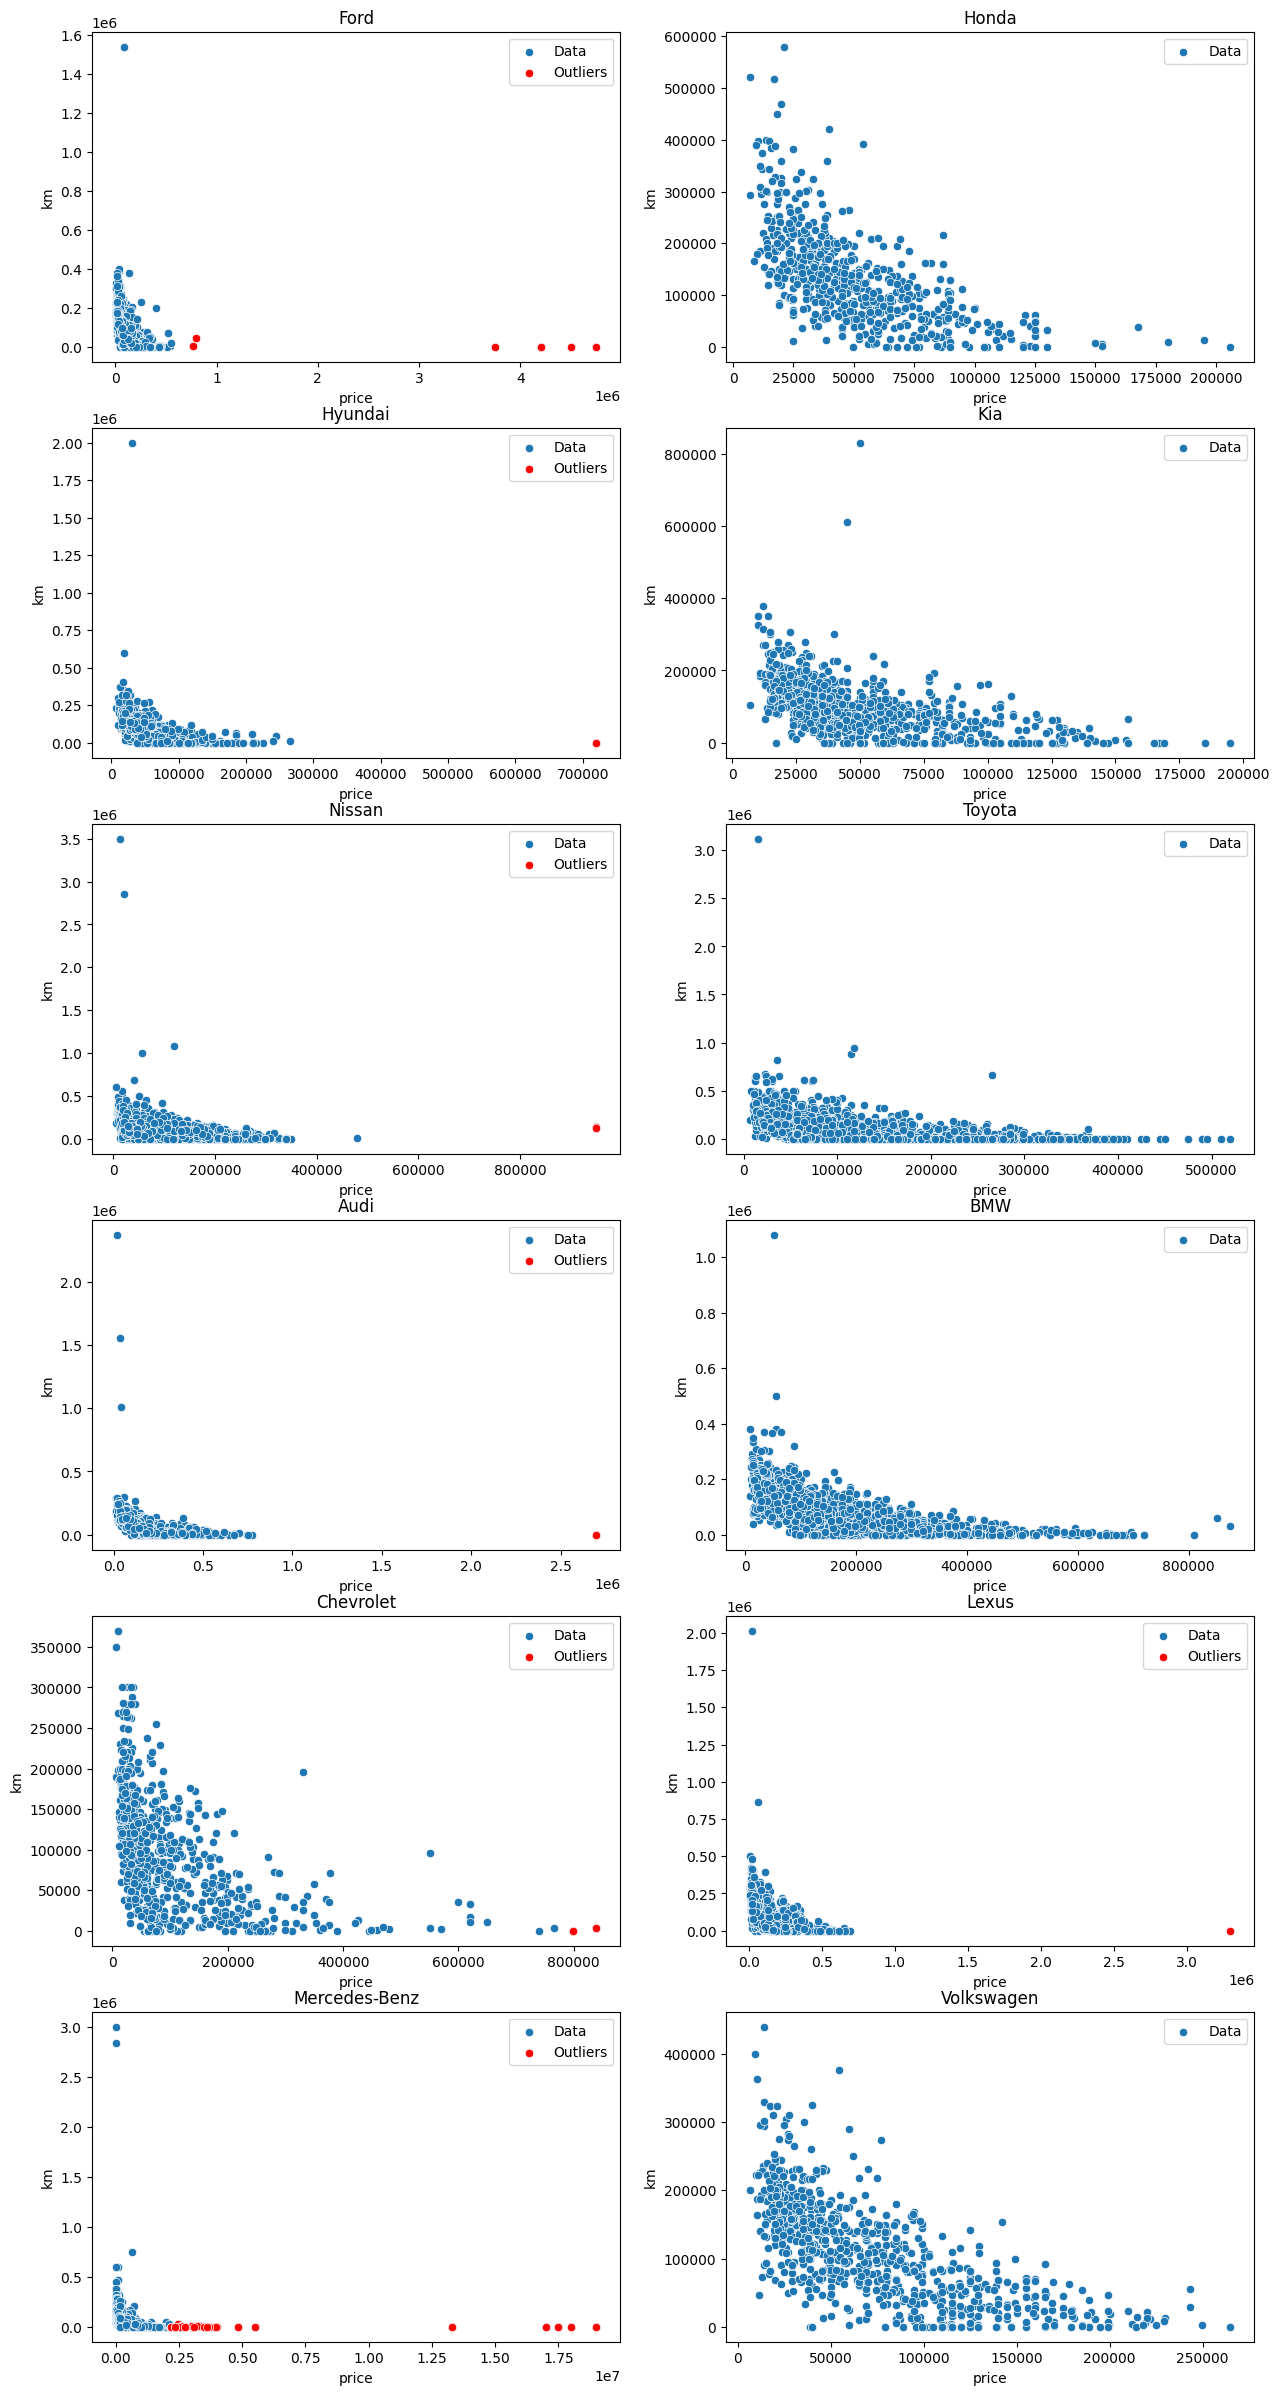

In [25]:
n_rows = len(brands) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for i, brand in enumerate(brands):
    ax = axes[i // 2, i % 2]
    brand_data = df[df['brand'] == brand]
    outliers = detect_outliers(brand_data, 'price')

    sns.scatterplot(data = brand_data, ax = ax, x='price', y='km', label='Data')
    sns.scatterplot(data = outliers, ax = ax, x='price', y='km', label='Outliers', color='red')

    ax.set_title(brand)

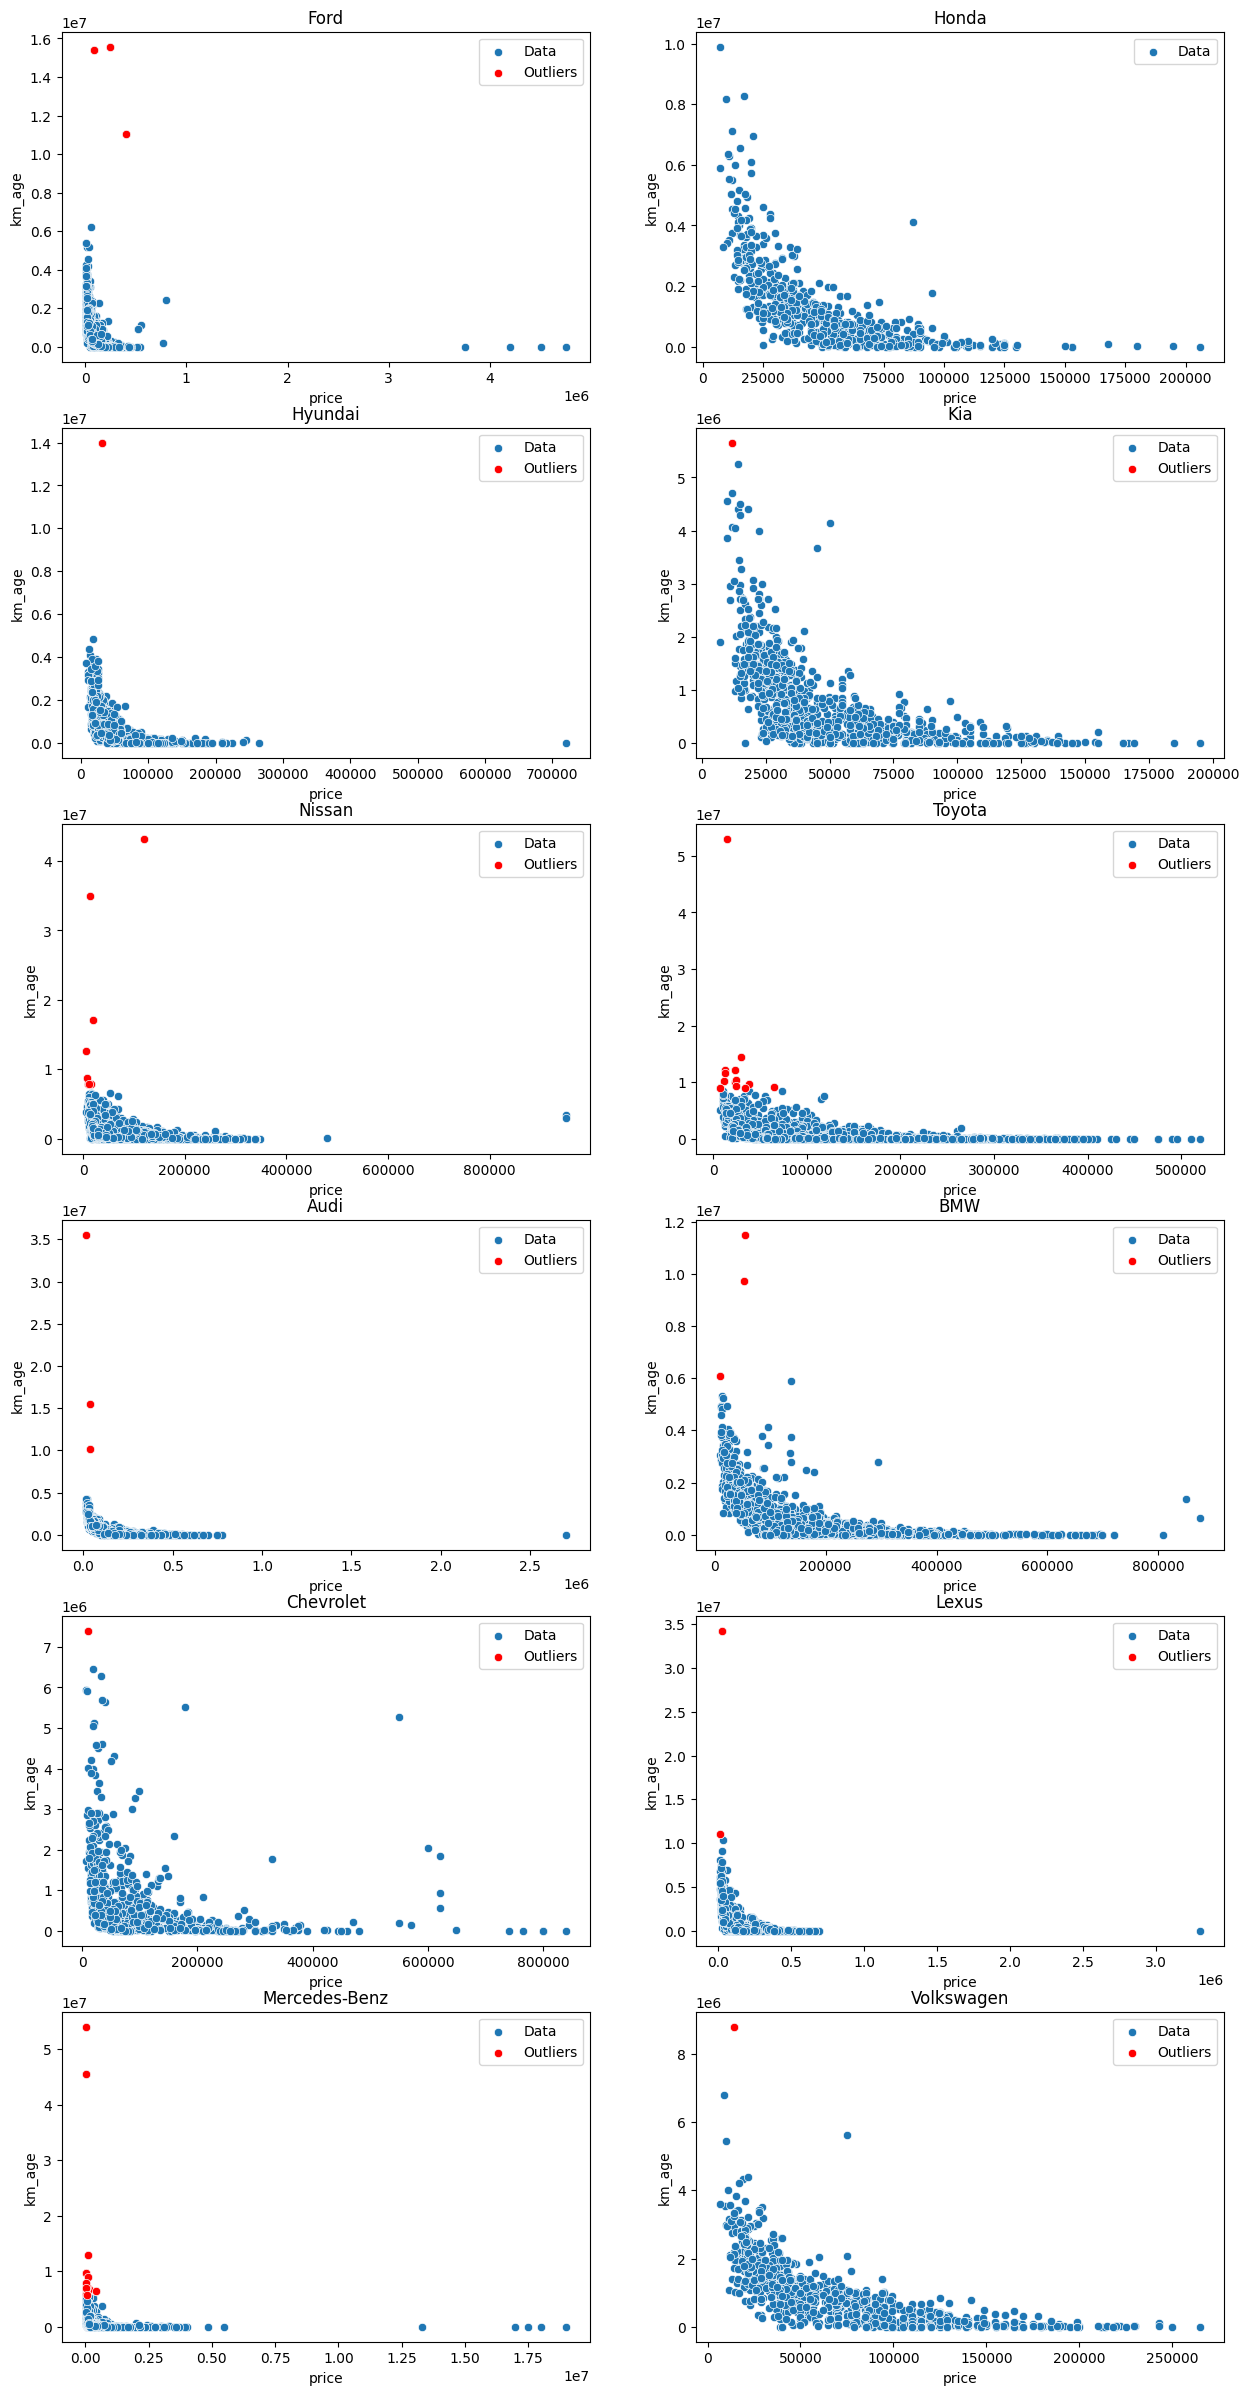

In [164]:
n_rows = len(brands) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for i, brand in enumerate(brands):
    ax = axes[i // 2, i % 2]
    brand_data = df[df['brand'] == brand]
    outliers = detect_outliers(brand_data, 'km_age')

    sns.scatterplot(data = brand_data, ax = ax, x='price', y='km_age', label='Data')
    sns.scatterplot(data = outliers, ax = ax, x='price', y='km_age', label='Outliers', color='red')

    ax.set_title(brand)

plt.savefig('../data/images/price-vs-km_age-scatterplot-by-car-brand.png')

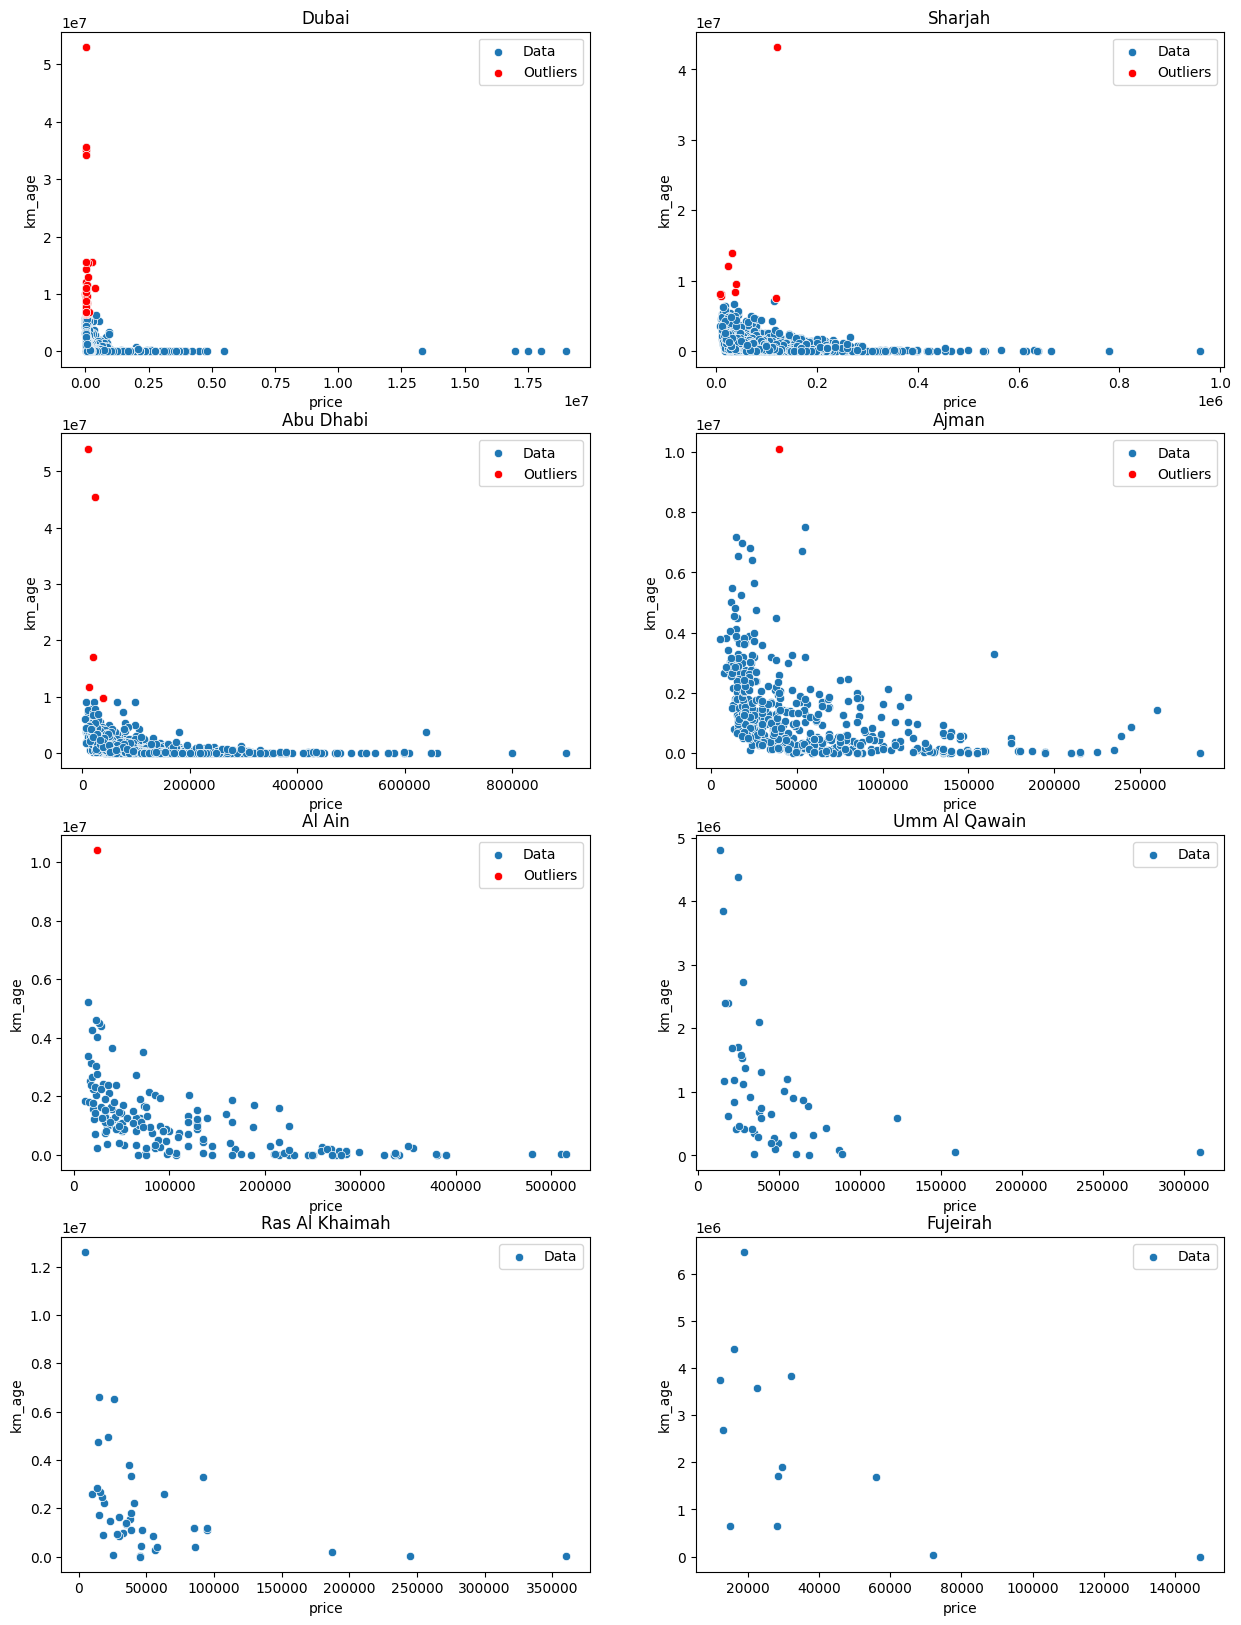

In [83]:
locations = df['location_cleaned'].unique()

n_rows = len(locations) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for i, location in enumerate(locations):
    ax = axes[i // 2, i % 2]
    brand_data = df[df['location_cleaned'] == location]
    outliers = detect_outliers(brand_data, 'km_age')

    sns.scatterplot(data = brand_data, ax = ax, x='price', y='km_age', label='Data')
    sns.scatterplot(data = outliers, ax = ax, x='price', y='km_age', label='Outliers', color='red')

    ax.set_title(location)

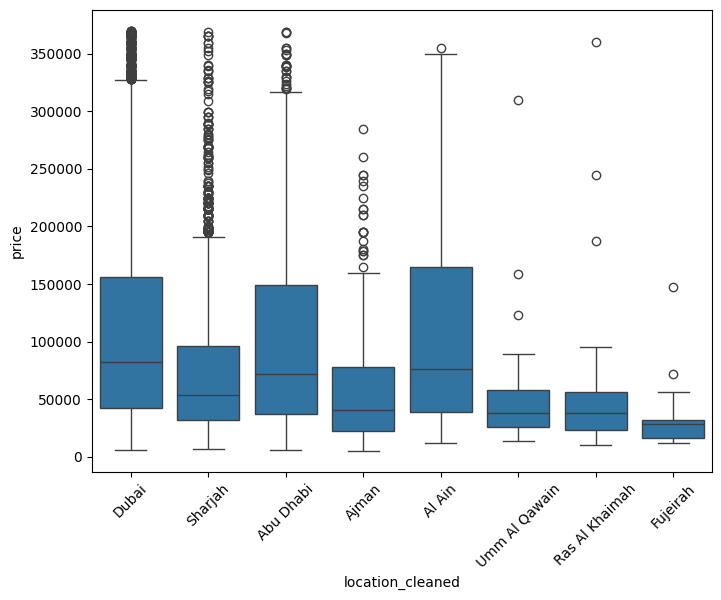

In [46]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(df_outlier_removed, x = 'location_cleaned', y = 'price')
plt.xticks(rotation=45);


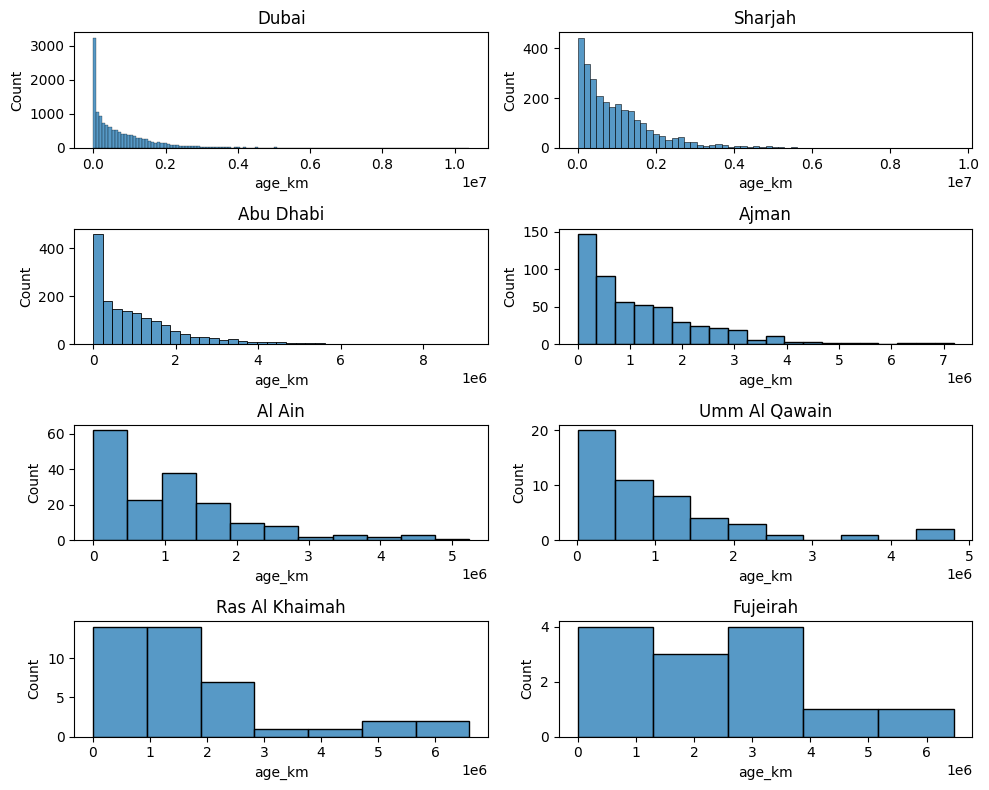

In [74]:
# Get the unique locations
locations = df_outlier_removed['location_cleaned'].unique()

# Calculate the number of rows needed for the subplots
n_rows = (len(locations) + 1) // 2  # Ensure enough rows for all locations

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2 * n_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each location and create a histogram
for i, location in enumerate(locations):
    loc_data = df_outlier_removed[df_outlier_removed['location_cleaned'] == location]
    sns.histplot(loc_data, x='age_km', ax=axes[i])
    axes[i].set_title(location)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

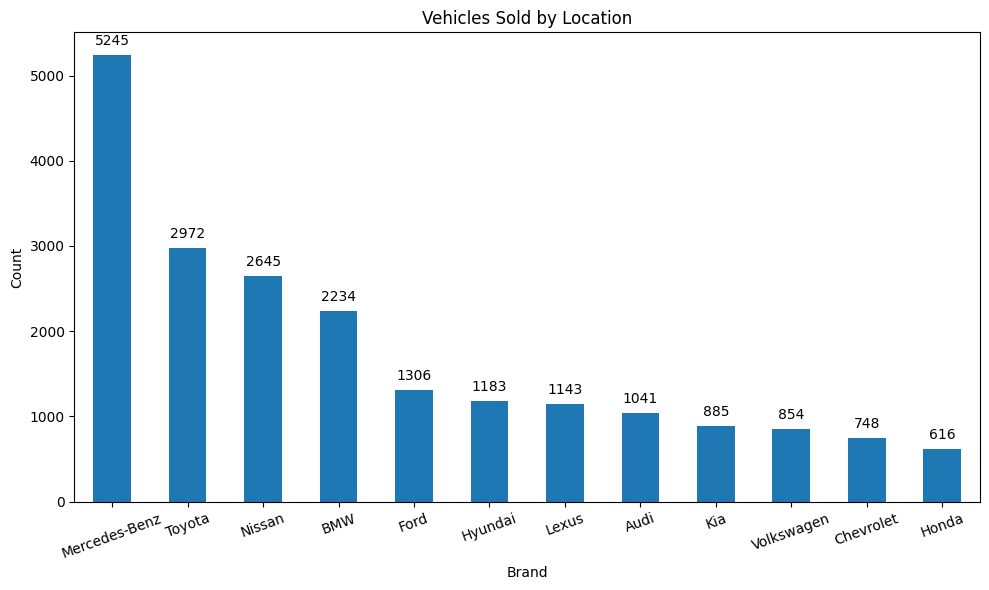

In [162]:
import matplotlib.pyplot as plt

# Create the bar plot
ax = (
    df
    .groupby(['brand'])
    .size()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(10, 6))
)

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set labels and title for better readability
ax.set_xlabel('Brand')
ax.set_ylabel('Count')
ax.set_title('Vehicles Sold by Location')

plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig('../data/images/vehicles-sold-by-brand.png')
plt.show()



In [108]:
df['brand'].unique()

array(['Ford', 'Honda', 'Hyundai', 'Kia', 'Nissan', 'Toyota', 'Audi',
       'BMW', 'Chevrolet', 'Lexus', 'Mercedes-Benz', 'Volkswagen'],
      dtype=object)

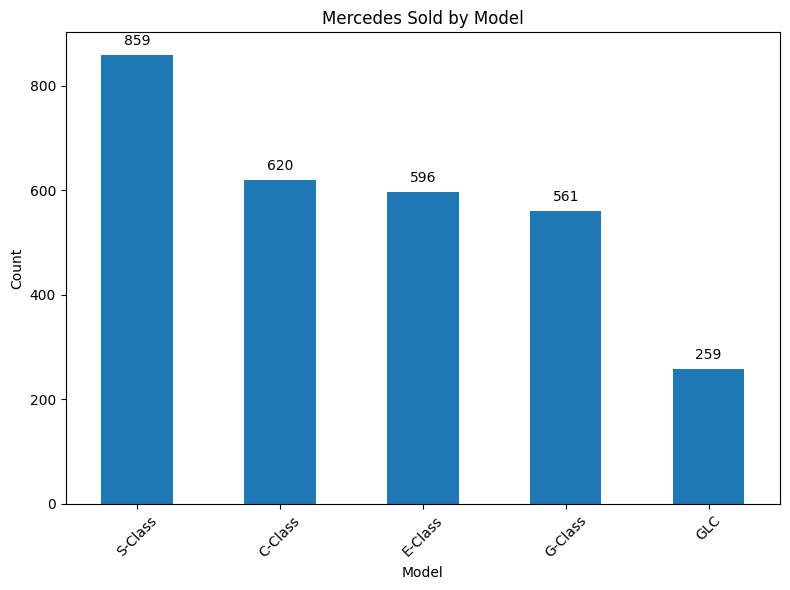

In [113]:
import matplotlib.pyplot as plt

# Create the bar plot
ax = (
    df[df['brand'] == 'Mercedes-Benz']
    .groupby(['model'])
    .size()
    .sort_values(ascending=False)
    .head(5)
    .plot(kind='bar', figsize=(8, 6))
)

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set labels and title for better readability
ax.set_xlabel('Model')
ax.set_ylabel('Count')
ax.set_title('Mercedes Sold by Model')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


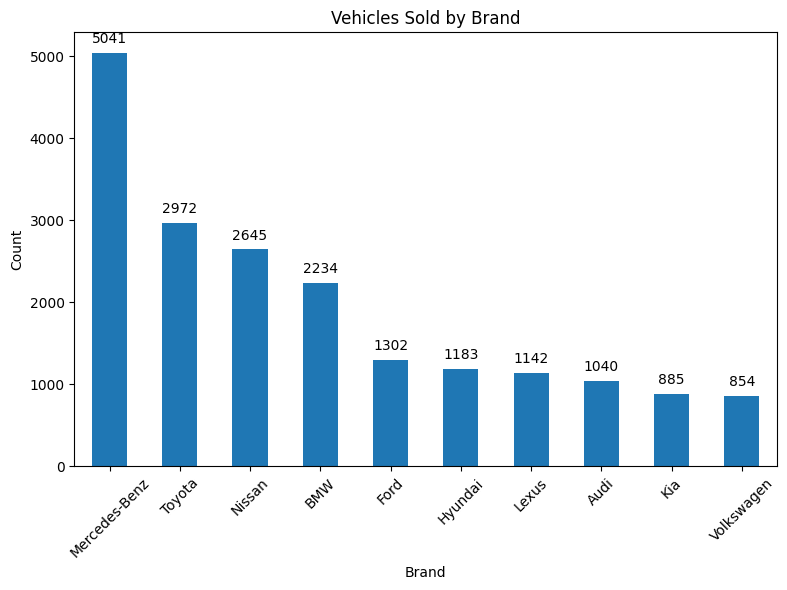

In [144]:
import matplotlib.pyplot as plt

# Create the bar plot
ax = (
    df[df['price'] < 1000000]
    .groupby(['brand'])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='bar', figsize=(8, 6))
)

# Add text annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set labels and title for better readability
ax.set_xlabel('Brand')
ax.set_ylabel('Count')
ax.set_title('Vehicles Sold by Brand')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


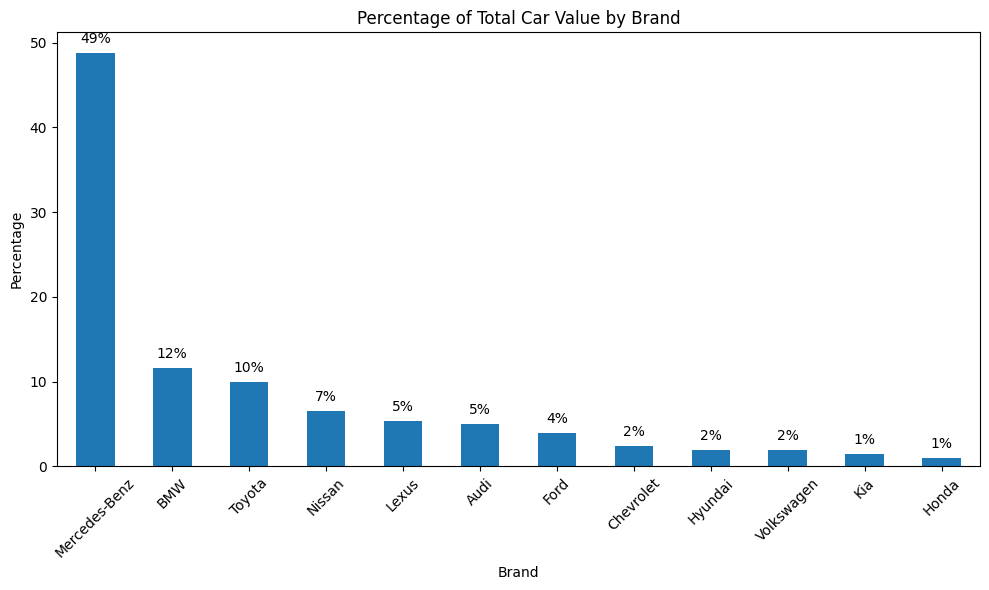

In [163]:
df_filtered = (
    df
    .groupby(['brand'])['price']
    .sum()
    .sort_values(ascending=False)
)

total_sum = df_filtered.sum()

df_filtered = df_filtered.to_frame().assign(percentage=lambda x: (x / total_sum) * 100)

# Plot the bar chart for the percentage values
ax = df_filtered['percentage'].plot(kind='bar', figsize=(10, 6))

# Add text annotations for the numeric values
for p in ax.patches:
    value = f"{p.get_height():.0f}%"
    ax.annotate(value, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set labels and title for better readability
ax.set_xlabel('Brand')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Total Car Value by Brand')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../data/images/sum-of-car-value-percentage.png')
plt.show()
